In [133]:
import pandas as pd
from datetime import datetime
from sklearn.metrics import mean_squared_error as mse 
from sklearn.metrics import mean_absolute_percentage_error as mape
import numpy as np
# from fbprophet import Prophet
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels
import pickle
from datetime import timedelta
from pytorch_forecasting.metrics import SMAPE
import torch

In [134]:
import pandas as pd
from datetime import datetime
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_percentage_error as mape
import numpy as np
# from fbprophet import Prophet
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels
import pickle
from datetime import timedelta
from pytorch_forecasting.metrics import SMAPE
import torch

# Load dataset

In [135]:
ts60 = pd.read_csv('../../VEOLIA/artifacts/timeseries_60min.csv', index_col=0, parse_dates=True)
tal60 = ts60['Diff Load Activa Total (60 minuto)'].dropna()
tal60.head()
tal60.to_csv('../../VEOLIA/artifacts/tal_60min.csv')

# Config
Steps for day ahead forecasts are preset to 24 (1 day)

In [136]:
steps = 24
days_ahead = 11

# Train / Test

In [137]:
last_train_day = datetime(2021, 6, 20)
train = tal60[:(last_train_day - timedelta(hours=1))]  
train = train.asfreq('H')
test = tal60[last_train_day:last_train_day+timedelta(hours=days_ahead*steps-1)]
test = test.asfreq('H')
# last_train_day_index = days_ahead * steps
# train = tal60.iloc[:-(last_train_day_index)]
# train = train.asfreq('H')
# test = tal60[len(train.index):]
# test = test.asfreq('H')


# Load weather & time variables

In [138]:
weather = pd.read_csv('../../VEOLIA/artifacts/weather_curated_60min.csv', index_col=0, parse_dates=True)[datetime(2020, 11, 6):]

time = pd.read_csv('../../VEOLIA/artifacts/time_60min.csv', index_col=1, parse_dates=True)[datetime(2020, 11, 6):]
time_useful = time[['weekday', 'weekend', 'holiday']].astype(int)

exog_testing = pd.concat((weather.loc[test.index], time_useful.loc[test.index]), axis=1)


# Load model from disk

In [139]:
def __getnewargs__(self):
    return (tuple(i for i in self.params_complete))

statsmodels.api.tsa.statespace.SARIMAX.__getnewargs__ = __getnewargs__

sarima = statsmodels.tsa.statespace.sarimax.SARIMAXResults.load('../../VEOLIA/models/tal_sarima.pkl')
sarimax = statsmodels.tsa.statespace.sarimax.SARIMAXResults.load('../../VEOLIA/models/tal_sarimax_plus_time_features.pkl')
print(sarima.summary())
print(sarimax.summary())

                                       SARIMAX Results                                        
Dep. Variable:     Diff Load Activa Total (60 minuto)   No. Observations:                 5424
Model:                 SARIMAX(4, 1, 1)x(1, 1, 1, 24)   Log Likelihood              -38231.968
Date:                                Tue, 24 Aug 2021   AIC                          76479.936
Time:                                        21:55:52   BIC                          76532.688
Sample:                                    11-06-2020   HQIC                         76498.353
                                         - 06-19-2021                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1055      0.051     -2.082      0.037      -0.205      -0.006
ar.

# Day ahead forecast 
## SARIMA

1 day ahead forecast:
MAPE naive: 0.10109781941365377
MAPE: 0.11836845951570914
MSE: 128549.33198505896
RMSE: 358.53776925877554


<Figure size 432x288 with 0 Axes>

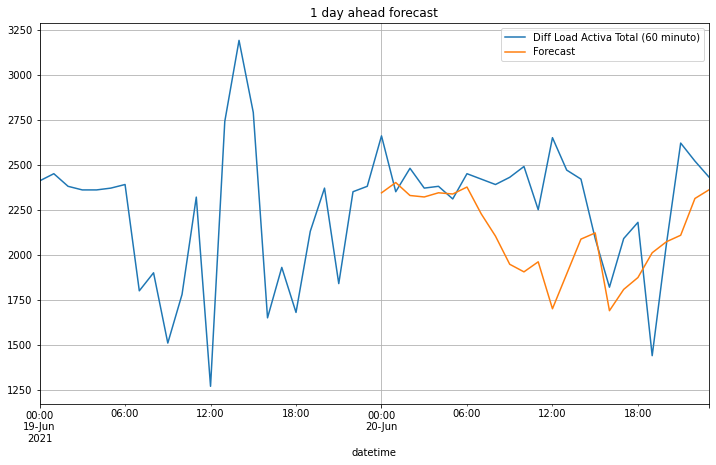

In [140]:
forecast_sarima = sarima.get_forecast(steps=steps)
predictions = forecast_sarima.summary_frame()['mean'].values
ground_truth = test[:steps]

# 1 day ahead forecast evaluation
print("1 day ahead forecast:")
naive_pred = [train.tolist()[-1]] + ground_truth[:-1].tolist()
print("MAPE naive:", mape(ground_truth, naive_pred))
print("MAPE:", mape(ground_truth, predictions))
print("MSE:", mse(ground_truth, predictions))
print("RMSE:", np.sqrt(mse(ground_truth, predictions)))

comparison_sarima = pd.DataFrame(ground_truth)
comparison_sarima['Forecast'] = predictions
training = pd.DataFrame(train, columns=comparison_sarima.filter(like='Diff').columns.tolist())
comparison_sarima = pd.concat([training, comparison_sarima])

plt.figure()
plot = comparison_sarima[datetime(2021, 6, 19):].plot(figsize=(12,7), 
                         title="1 day ahead forecast")
plot.grid()


## SARIMAX

1 day ahead forecast:
MAPE naive: 0.10109781941365377
MAPE: 0.09551483228238293
MSE: 74332.24077387102
RMSE: 272.63939695845687


<Figure size 432x288 with 0 Axes>

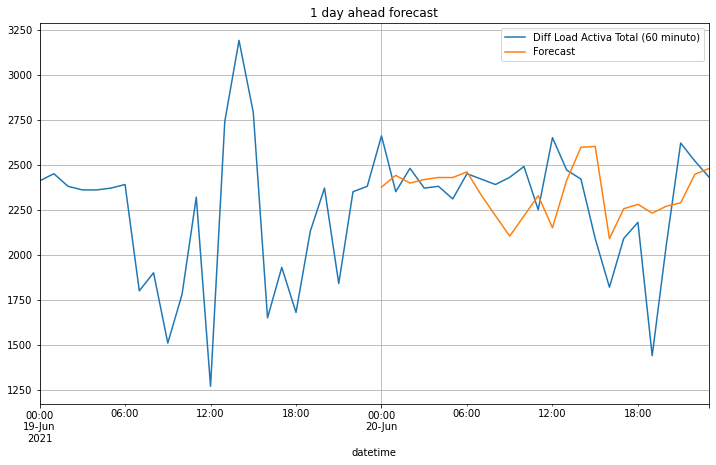

In [141]:
forecast_sarimax = sarimax.get_forecast(steps=steps, exog=exog_testing[:steps])
predictions = forecast_sarimax.summary_frame()['mean'].values
ground_truth = test[:steps]

# 1 day ahead forecast evaluation
print("1 day ahead forecast:")
naive_pred = [train.tolist()[-1]] + ground_truth[:-1].tolist()
print("MAPE naive:", mape(ground_truth, naive_pred))
print("MAPE:", mape(ground_truth, predictions))
print("MSE:", mse(ground_truth, predictions))
print("RMSE:", np.sqrt(mse(ground_truth, predictions)))

comparison_sarima = pd.DataFrame(ground_truth)
comparison_sarima['Forecast'] = predictions
training = pd.DataFrame(
    train, columns=comparison_sarima.filter(like='Diff').columns.tolist())
comparison_sarima = pd.concat([training, comparison_sarima])

plt.figure()
plot = comparison_sarima[datetime(2021, 6, 19):].plot(figsize=(12, 7),
                                                      title="1 day ahead forecast")
plot.grid()


Largest improvement is observed here using the ARIMAX model. SARIMA performs worse than Naive. However 1 day is not enough to judge the performance of the model as such results can be due to randomness of the specific day.

# Simple 11-day ahead forecast with error propagation
## SARIMA

Simple 11 day ahead forecast:
MAPE naive: 0.12932806959843607
MAPE: 0.1197298881697591
MSE: 103081.85389991474
RMSE: 321.0636290518045


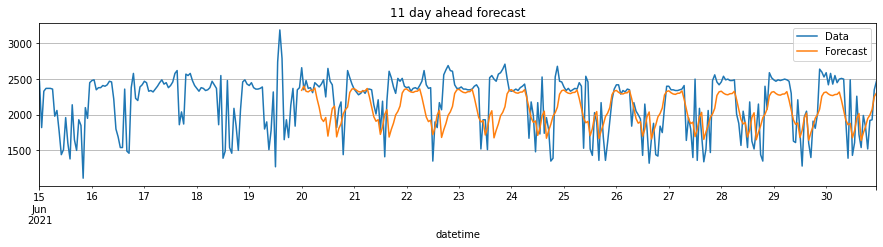

In [142]:
print(f"Simple {days_ahead} day ahead forecast:")
predictions = sarima.forecast(steps * days_ahead)
ground_truth_line = pd.concat([train[-5*24:], test])

naive_pred = [train.tolist()[-1]] + test.tolist()[:-1]
print("MAPE naive:", mape(test, naive_pred))
print("MAPE:", mape(test, predictions))
print("MSE:", mse(test, predictions))
print("RMSE:", np.sqrt(mse(test, predictions)))

plt.figure()
plot = ground_truth_line.plot(figsize=(15, 3), label='Data', legend=True, title=f"{days_ahead} day ahead forecast")
predictions.plot(label='Forecast', legend=True)
plot.grid()
plt.show()


## SARIMAX

Simple 11 day ahead forecast:
MAPE naive: 0.12932806959843607
MAPE: 0.11504785216340577
MSE: 83405.6248210634
RMSE: 288.80031998088816


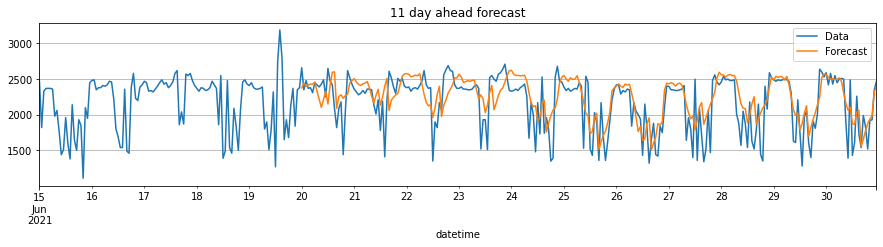

In [143]:
print(f"Simple {days_ahead} day ahead forecast:")
predictions = sarimax.forecast(steps * days_ahead, exog=exog_testing)
ground_truth_line = pd.concat([train[-int(days_ahead/2) * steps:], test])

naive_pred = [train.tolist()[-1]] + test.tolist()[:-1]
print("MAPE naive:", mape(test, naive_pred))
print("MAPE:", mape(test, predictions))
print("MSE:", mse(test, predictions))
print("RMSE:", np.sqrt(mse(test, predictions)))

plt.figure()
plot = ground_truth_line.plot(figsize=(
    15, 3), label='Data', legend=True, title=f"{days_ahead} day ahead forecast")
predictions.plot(label='Forecast', legend=True)
plot.grid()
plt.show()


# Advanced 11-day ahead forecast with news update every 24h (no refitting)


## SARIMA

Advanced 11 day ahead forecast:
MAPE naive: 0.12932806959843607
SMAPE naive: 0.12687601149082184


MAPE: 0.1268356057551639
SMAPE: 0.12023001164197922
MSE: 100159.56125088528
RMSE: 316.4799539479322


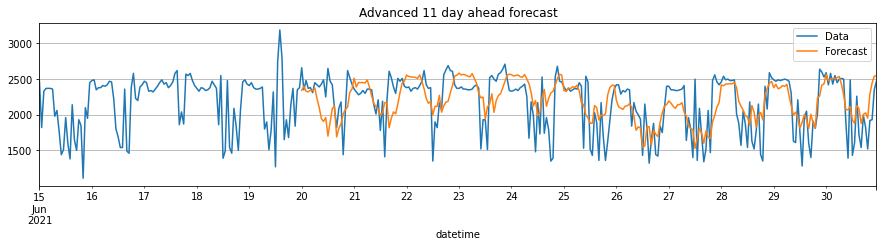

In [144]:
print(f"Advanced {days_ahead} day ahead forecast:")
ground_truth_line = pd.concat([train[-5 * steps:], test])

predictions = pd.Series(dtype='float64')
for n_day in range(days_ahead):
    cur_timestep = n_day * steps
    next_timestep =  cur_timestep + steps
    day_preds = sarima.forecast(steps)
    predictions = pd.concat([predictions, day_preds])
    y_news = test.iloc[cur_timestep: next_timestep]
    y_news = y_news.asfreq('H')
    sarima = sarima.append(y_news)

predictions.name = test.name
predictions = predictions.rename_axis('datetime')

# Evaluation metrix
naive_pred = [train.tolist()[-1]] + test.tolist()[:-1]
print("MAPE naive:", mape(test, naive_pred))
print(f"SMAPE naive: {SMAPE()(torch.FloatTensor(test).unsqueeze(1), torch.FloatTensor(naive_pred).unsqueeze(1)).item()}")
print("\n================================\n")
print("MAPE:", mape(test, predictions))
print("SMAPE:", SMAPE()(torch.FloatTensor(test).unsqueeze(1), torch.FloatTensor(predictions).unsqueeze(1)).item())
print("MSE:", mse(test, predictions))
print("RMSE:", np.sqrt(mse(test, predictions)))

# Plot the last 5 days of data and the 11 days of forecast
plt.figure()
plot = ground_truth_line.plot(figsize=(15, 3), label='Data', legend=True, title=f"Advanced {days_ahead} day ahead forecast")
predictions.plot(label='Forecast', legend=True)
plot.grid()
plt.show()

- In most cases the ARIMA model performs a bit better but close to Naive. The SARIMA model is excluded for 1 the 1 day ahead forecasts. However this can be due to randomness of the specific test day.
- ARIMAX significantly improves the results in all cases.
- However, statsmodels does not provide news update with exogenous variables so we do not proceed with SARIMAX for the advanced 11-day forecast.